# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.53KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


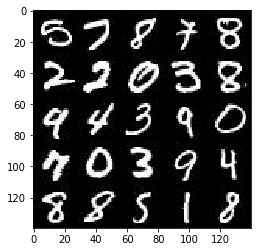

In [2]:
show_n_images = 33

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

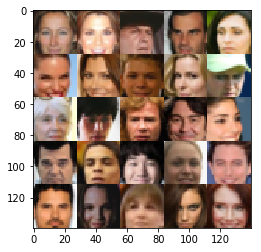

In [3]:
show_n_images = 33

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return real_input,z, learning_rate

   

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.1
    keep_prob = 0.5
    with tf.variable_scope('discriminator', reuse=reuse):
           
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
      #  dropout1=tf.layers.dropout(relu1)
        dropout1 = tf.nn.dropout(relu1, keep_prob)
        # 16x16x64
        
        x2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
       # dropout2=tf.layers.dropout(relu2)
        dropout2 = tf.nn.dropout(relu2, keep_prob)
        # 8x8x128
        
        x3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
      #  dropout3=tf.layers.dropout(relu3)
        dropout3 = tf.nn.dropout(relu3, keep_prob)
        # 4x4x256

        # Flattened by reshaping the tensor
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
      #  dropout_logits=tf.layers.dropout(logits)
        dropout_logits = tf.nn.dropout(logits, keep_prob)
        out = tf.sigmoid(dropout_logits)
        
       

   


    return out, dropout_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    gen_alpha=0.1
    with tf.variable_scope('generator', reuse= not is_train ):
        # First fully connected layer
       # x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.layers.dense(z, 7*7*64)
        # Reshaped tensor to build the convolutional neural network
      #  x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.reshape(x1, (-1, 7, 7, 64))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(gen_alpha * bn1, bn1)
        # 7x7x512
        
     #   x2 = tf.layers.conv2d_transpose(relu1, 256,5 , strides=2, padding='same')
        x2 = tf.layers.conv2d_transpose(relu1, 32,5 , strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(gen_alpha * bn2, bn2)
        # 14x14x256 
        
    #    x3 = tf.layers.conv2d_transpose(relu2, 128,5 , strides=2, padding='same')
        x3 = tf.layers.conv2d_transpose(relu2, 16,5 , strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(gen_alpha * bn3, bn3)
         # 28x28x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same') 
        #28x28x5
     
    #   # 56x56x128        
    #    logits = tf.reshape(logits,(-1,28,28,5))
    #    #28x28x5
        
        out = tf.tanh(logits)
           
    return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.1
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    
    
    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)   
    d_update_ops = [var for var in update_ops if var.name.startswith('discriminator')]
    g_update_ops = [var for var in update_ops if var.name.startswith('generator')]

    # Optimization of Discriminator variables and Generator Variables
  #  d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
  #  g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
   # d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars) 
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars) 
        
    with tf.control_dependencies(g_update_ops):   
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
       
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    output_dim = data_shape[3]


    input_real, input_z, learn_rate = model_inputs(image_width, image_height, output_dim, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, output_dim)

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                #Rescaling images
                batch_images *= 2.0
               
                # Random Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
             
                # Optimizing
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 2nd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 3rd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Determine losses and print
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, output_dim, data_image_mode)

    return None
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch# 10... Discriminator Loss: 6.4619... Generator Loss: 0.2495
Epoch 1/2 Batch# 20... Discriminator Loss: 2.7620... Generator Loss: 0.7198
Epoch 1/2 Batch# 30... Discriminator Loss: 2.4465... Generator Loss: 0.5804
Epoch 1/2 Batch# 40... Discriminator Loss: 2.6599... Generator Loss: 0.5766
Epoch 1/2 Batch# 50... Discriminator Loss: 2.5532... Generator Loss: 0.7579
Epoch 1/2 Batch# 60... Discriminator Loss: 2.4122... Generator Loss: 1.2294
Epoch 1/2 Batch# 70... Discriminator Loss: 2.1142... Generator Loss: 0.6466
Epoch 1/2 Batch# 80... Discriminator Loss: 1.9439... Generator Loss: 0.9724
Epoch 1/2 Batch# 90... Discriminator Loss: 1.8578... Generator Loss: 0.7807
Epoch 1/2 Batch# 100... Discriminator Loss: 2.1629... Generator Loss: 1.7232


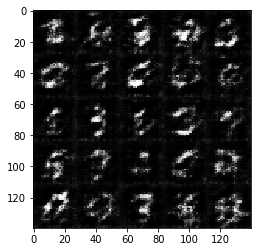

Epoch 1/2 Batch# 110... Discriminator Loss: 1.8018... Generator Loss: 1.2100
Epoch 1/2 Batch# 120... Discriminator Loss: 1.8098... Generator Loss: 1.0267
Epoch 1/2 Batch# 130... Discriminator Loss: 1.5649... Generator Loss: 0.7127
Epoch 1/2 Batch# 140... Discriminator Loss: 1.8151... Generator Loss: 0.6796
Epoch 1/2 Batch# 150... Discriminator Loss: 1.6670... Generator Loss: 0.6691
Epoch 1/2 Batch# 160... Discriminator Loss: 1.6610... Generator Loss: 0.7564
Epoch 1/2 Batch# 170... Discriminator Loss: 1.4641... Generator Loss: 1.1800
Epoch 1/2 Batch# 180... Discriminator Loss: 1.5763... Generator Loss: 0.8060
Epoch 1/2 Batch# 190... Discriminator Loss: 1.5974... Generator Loss: 0.8735
Epoch 1/2 Batch# 200... Discriminator Loss: 1.6016... Generator Loss: 0.9401


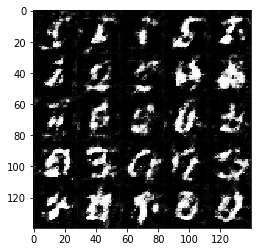

Epoch 1/2 Batch# 210... Discriminator Loss: 1.6429... Generator Loss: 0.7860
Epoch 1/2 Batch# 220... Discriminator Loss: 1.6216... Generator Loss: 0.8172
Epoch 1/2 Batch# 230... Discriminator Loss: 1.6366... Generator Loss: 0.8493
Epoch 1/2 Batch# 240... Discriminator Loss: 1.5249... Generator Loss: 0.7436
Epoch 1/2 Batch# 250... Discriminator Loss: 1.5340... Generator Loss: 0.7032
Epoch 1/2 Batch# 260... Discriminator Loss: 1.6250... Generator Loss: 0.6508
Epoch 1/2 Batch# 270... Discriminator Loss: 1.6948... Generator Loss: 0.5734
Epoch 1/2 Batch# 280... Discriminator Loss: 1.5239... Generator Loss: 0.9434
Epoch 1/2 Batch# 290... Discriminator Loss: 1.6218... Generator Loss: 0.5248
Epoch 1/2 Batch# 300... Discriminator Loss: 1.5930... Generator Loss: 0.8061


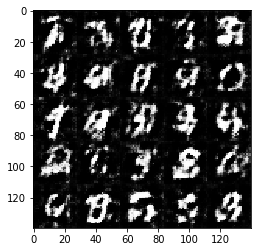

Epoch 1/2 Batch# 310... Discriminator Loss: 1.4784... Generator Loss: 1.0102
Epoch 1/2 Batch# 320... Discriminator Loss: 1.4882... Generator Loss: 0.7202
Epoch 1/2 Batch# 330... Discriminator Loss: 1.4746... Generator Loss: 0.9283
Epoch 1/2 Batch# 340... Discriminator Loss: 1.6529... Generator Loss: 1.0786
Epoch 1/2 Batch# 350... Discriminator Loss: 1.5255... Generator Loss: 0.8963
Epoch 1/2 Batch# 360... Discriminator Loss: 1.5878... Generator Loss: 1.0503
Epoch 1/2 Batch# 370... Discriminator Loss: 1.4384... Generator Loss: 0.6597
Epoch 1/2 Batch# 380... Discriminator Loss: 1.4887... Generator Loss: 0.8841
Epoch 1/2 Batch# 390... Discriminator Loss: 1.6197... Generator Loss: 0.9149
Epoch 1/2 Batch# 400... Discriminator Loss: 1.4712... Generator Loss: 0.7525


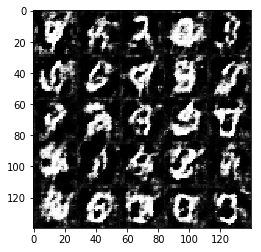

Epoch 1/2 Batch# 410... Discriminator Loss: 1.5524... Generator Loss: 0.9715
Epoch 1/2 Batch# 420... Discriminator Loss: 1.3648... Generator Loss: 0.6312
Epoch 1/2 Batch# 430... Discriminator Loss: 1.5279... Generator Loss: 1.0378
Epoch 1/2 Batch# 440... Discriminator Loss: 1.5858... Generator Loss: 0.5876
Epoch 1/2 Batch# 450... Discriminator Loss: 1.5673... Generator Loss: 0.5769
Epoch 1/2 Batch# 460... Discriminator Loss: 1.4197... Generator Loss: 0.8285
Epoch 1/2 Batch# 470... Discriminator Loss: 1.4604... Generator Loss: 1.0648
Epoch 1/2 Batch# 480... Discriminator Loss: 1.5159... Generator Loss: 0.5454
Epoch 1/2 Batch# 490... Discriminator Loss: 1.4160... Generator Loss: 0.8075
Epoch 1/2 Batch# 500... Discriminator Loss: 1.5398... Generator Loss: 0.5671


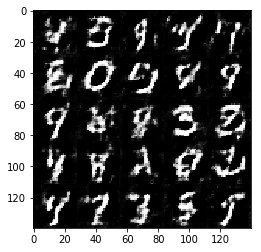

Epoch 1/2 Batch# 510... Discriminator Loss: 1.4196... Generator Loss: 0.7790
Epoch 1/2 Batch# 520... Discriminator Loss: 1.4538... Generator Loss: 0.9098
Epoch 1/2 Batch# 530... Discriminator Loss: 1.5971... Generator Loss: 0.4888
Epoch 1/2 Batch# 540... Discriminator Loss: 1.4542... Generator Loss: 0.9715
Epoch 1/2 Batch# 550... Discriminator Loss: 1.3912... Generator Loss: 0.6837
Epoch 1/2 Batch# 560... Discriminator Loss: 1.5775... Generator Loss: 0.5528
Epoch 1/2 Batch# 570... Discriminator Loss: 1.4829... Generator Loss: 0.8999
Epoch 1/2 Batch# 580... Discriminator Loss: 1.4959... Generator Loss: 0.6696
Epoch 1/2 Batch# 590... Discriminator Loss: 1.4268... Generator Loss: 0.8577
Epoch 1/2 Batch# 600... Discriminator Loss: 1.5236... Generator Loss: 1.1558


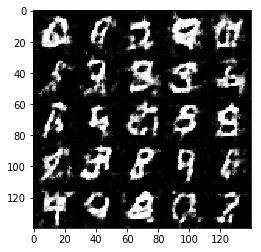

Epoch 1/2 Batch# 610... Discriminator Loss: 1.6929... Generator Loss: 0.5795
Epoch 1/2 Batch# 620... Discriminator Loss: 1.4190... Generator Loss: 0.9161
Epoch 1/2 Batch# 630... Discriminator Loss: 1.7604... Generator Loss: 0.5630
Epoch 1/2 Batch# 640... Discriminator Loss: 1.4573... Generator Loss: 0.5984
Epoch 1/2 Batch# 650... Discriminator Loss: 1.4628... Generator Loss: 0.7293
Epoch 1/2 Batch# 660... Discriminator Loss: 1.4301... Generator Loss: 0.9570
Epoch 1/2 Batch# 670... Discriminator Loss: 1.4780... Generator Loss: 0.6035
Epoch 1/2 Batch# 680... Discriminator Loss: 1.4360... Generator Loss: 0.8546
Epoch 1/2 Batch# 690... Discriminator Loss: 1.2868... Generator Loss: 0.7310
Epoch 1/2 Batch# 700... Discriminator Loss: 1.4169... Generator Loss: 0.8322


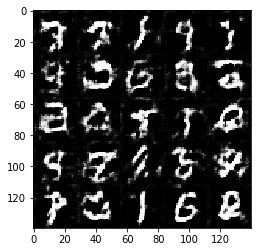

Epoch 1/2 Batch# 710... Discriminator Loss: 1.4767... Generator Loss: 0.9147
Epoch 1/2 Batch# 720... Discriminator Loss: 1.4430... Generator Loss: 0.9060
Epoch 1/2 Batch# 730... Discriminator Loss: 1.4527... Generator Loss: 0.8409
Epoch 1/2 Batch# 740... Discriminator Loss: 1.4178... Generator Loss: 0.6659
Epoch 1/2 Batch# 750... Discriminator Loss: 1.4189... Generator Loss: 0.6827
Epoch 1/2 Batch# 760... Discriminator Loss: 1.4014... Generator Loss: 0.7383
Epoch 1/2 Batch# 770... Discriminator Loss: 1.4725... Generator Loss: 0.6880
Epoch 1/2 Batch# 780... Discriminator Loss: 1.4626... Generator Loss: 0.8458
Epoch 1/2 Batch# 790... Discriminator Loss: 1.4226... Generator Loss: 0.9318
Epoch 1/2 Batch# 800... Discriminator Loss: 1.4346... Generator Loss: 0.7111


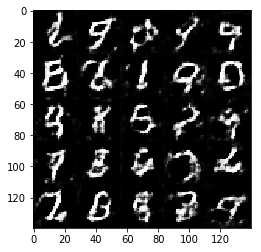

Epoch 1/2 Batch# 810... Discriminator Loss: 1.3866... Generator Loss: 0.8649
Epoch 1/2 Batch# 820... Discriminator Loss: 1.4477... Generator Loss: 0.7182
Epoch 1/2 Batch# 830... Discriminator Loss: 1.4705... Generator Loss: 0.8973
Epoch 1/2 Batch# 840... Discriminator Loss: 1.5529... Generator Loss: 0.5517
Epoch 1/2 Batch# 850... Discriminator Loss: 1.4937... Generator Loss: 0.6084
Epoch 1/2 Batch# 860... Discriminator Loss: 1.4222... Generator Loss: 0.6129
Epoch 1/2 Batch# 870... Discriminator Loss: 1.3595... Generator Loss: 0.8307
Epoch 1/2 Batch# 880... Discriminator Loss: 1.3925... Generator Loss: 0.7312
Epoch 1/2 Batch# 890... Discriminator Loss: 1.4109... Generator Loss: 0.6847
Epoch 1/2 Batch# 900... Discriminator Loss: 1.3721... Generator Loss: 0.7781


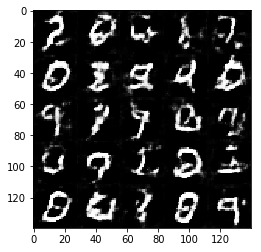

Epoch 1/2 Batch# 910... Discriminator Loss: 1.6771... Generator Loss: 1.1244
Epoch 1/2 Batch# 920... Discriminator Loss: 1.4527... Generator Loss: 0.9132
Epoch 1/2 Batch# 930... Discriminator Loss: 1.4403... Generator Loss: 0.7442
Epoch 2/2 Batch# 940... Discriminator Loss: 1.4112... Generator Loss: 0.8720
Epoch 2/2 Batch# 950... Discriminator Loss: 1.5722... Generator Loss: 1.0308
Epoch 2/2 Batch# 960... Discriminator Loss: 1.3918... Generator Loss: 0.6539
Epoch 2/2 Batch# 970... Discriminator Loss: 1.4059... Generator Loss: 0.8894
Epoch 2/2 Batch# 980... Discriminator Loss: 1.4295... Generator Loss: 0.7002
Epoch 2/2 Batch# 990... Discriminator Loss: 1.7446... Generator Loss: 1.2745
Epoch 2/2 Batch# 1000... Discriminator Loss: 1.4120... Generator Loss: 0.7373


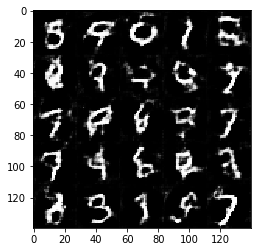

Epoch 2/2 Batch# 1010... Discriminator Loss: 1.4351... Generator Loss: 0.9987
Epoch 2/2 Batch# 1020... Discriminator Loss: 1.4276... Generator Loss: 0.8306
Epoch 2/2 Batch# 1030... Discriminator Loss: 1.5545... Generator Loss: 0.9470
Epoch 2/2 Batch# 1040... Discriminator Loss: 1.4276... Generator Loss: 0.7419
Epoch 2/2 Batch# 1050... Discriminator Loss: 1.4979... Generator Loss: 0.7152
Epoch 2/2 Batch# 1060... Discriminator Loss: 1.5326... Generator Loss: 1.0366
Epoch 2/2 Batch# 1070... Discriminator Loss: 1.4234... Generator Loss: 0.6539
Epoch 2/2 Batch# 1080... Discriminator Loss: 1.4124... Generator Loss: 0.6802
Epoch 2/2 Batch# 1090... Discriminator Loss: 1.5532... Generator Loss: 0.5361
Epoch 2/2 Batch# 1100... Discriminator Loss: 1.4231... Generator Loss: 0.7145


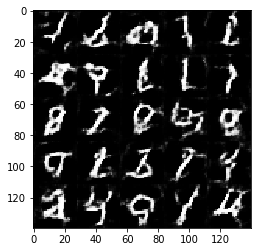

Epoch 2/2 Batch# 1110... Discriminator Loss: 1.4631... Generator Loss: 0.6995
Epoch 2/2 Batch# 1120... Discriminator Loss: 1.4254... Generator Loss: 0.5507
Epoch 2/2 Batch# 1130... Discriminator Loss: 1.6796... Generator Loss: 0.5579
Epoch 2/2 Batch# 1140... Discriminator Loss: 1.4810... Generator Loss: 0.6408
Epoch 2/2 Batch# 1150... Discriminator Loss: 1.4593... Generator Loss: 0.6953
Epoch 2/2 Batch# 1160... Discriminator Loss: 1.5111... Generator Loss: 0.9952
Epoch 2/2 Batch# 1170... Discriminator Loss: 1.4261... Generator Loss: 0.7951
Epoch 2/2 Batch# 1180... Discriminator Loss: 1.3455... Generator Loss: 0.7663
Epoch 2/2 Batch# 1190... Discriminator Loss: 1.3849... Generator Loss: 0.8992
Epoch 2/2 Batch# 1200... Discriminator Loss: 1.4247... Generator Loss: 0.6596


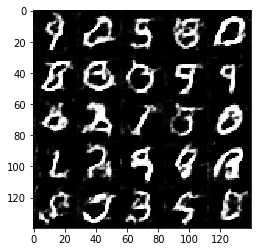

Epoch 2/2 Batch# 1210... Discriminator Loss: 1.3826... Generator Loss: 0.7641
Epoch 2/2 Batch# 1220... Discriminator Loss: 1.4056... Generator Loss: 0.6974
Epoch 2/2 Batch# 1230... Discriminator Loss: 1.3873... Generator Loss: 0.7382
Epoch 2/2 Batch# 1240... Discriminator Loss: 1.4398... Generator Loss: 0.8186
Epoch 2/2 Batch# 1250... Discriminator Loss: 1.3719... Generator Loss: 0.7978
Epoch 2/2 Batch# 1260... Discriminator Loss: 1.4488... Generator Loss: 0.6811
Epoch 2/2 Batch# 1270... Discriminator Loss: 1.4051... Generator Loss: 0.7887
Epoch 2/2 Batch# 1280... Discriminator Loss: 1.3779... Generator Loss: 0.8096
Epoch 2/2 Batch# 1290... Discriminator Loss: 1.3991... Generator Loss: 0.6957
Epoch 2/2 Batch# 1300... Discriminator Loss: 1.3964... Generator Loss: 0.7586


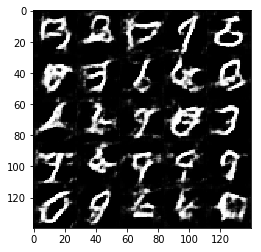

Epoch 2/2 Batch# 1310... Discriminator Loss: 1.5550... Generator Loss: 0.9711
Epoch 2/2 Batch# 1320... Discriminator Loss: 1.3349... Generator Loss: 0.7693
Epoch 2/2 Batch# 1330... Discriminator Loss: 1.3804... Generator Loss: 0.7239
Epoch 2/2 Batch# 1340... Discriminator Loss: 1.3382... Generator Loss: 0.7445
Epoch 2/2 Batch# 1350... Discriminator Loss: 1.3932... Generator Loss: 0.7806
Epoch 2/2 Batch# 1360... Discriminator Loss: 1.5599... Generator Loss: 0.9800
Epoch 2/2 Batch# 1370... Discriminator Loss: 1.3797... Generator Loss: 0.7734
Epoch 2/2 Batch# 1380... Discriminator Loss: 1.4540... Generator Loss: 0.6320
Epoch 2/2 Batch# 1390... Discriminator Loss: 1.4001... Generator Loss: 0.7573
Epoch 2/2 Batch# 1400... Discriminator Loss: 1.3522... Generator Loss: 0.8903


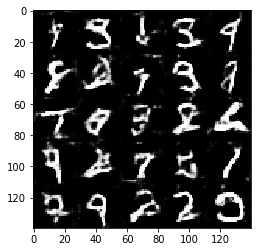

Epoch 2/2 Batch# 1410... Discriminator Loss: 1.4189... Generator Loss: 0.7108
Epoch 2/2 Batch# 1420... Discriminator Loss: 1.3879... Generator Loss: 0.7286
Epoch 2/2 Batch# 1430... Discriminator Loss: 1.3208... Generator Loss: 0.7449
Epoch 2/2 Batch# 1440... Discriminator Loss: 1.4549... Generator Loss: 0.6446
Epoch 2/2 Batch# 1450... Discriminator Loss: 1.4169... Generator Loss: 0.7737
Epoch 2/2 Batch# 1460... Discriminator Loss: 1.6383... Generator Loss: 0.5478
Epoch 2/2 Batch# 1470... Discriminator Loss: 1.4375... Generator Loss: 0.7152
Epoch 2/2 Batch# 1480... Discriminator Loss: 1.4391... Generator Loss: 0.6732
Epoch 2/2 Batch# 1490... Discriminator Loss: 1.3475... Generator Loss: 0.8533
Epoch 2/2 Batch# 1500... Discriminator Loss: 1.5319... Generator Loss: 0.5873


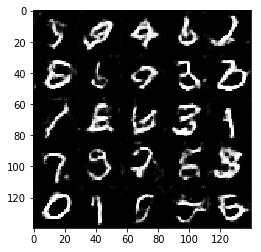

Epoch 2/2 Batch# 1510... Discriminator Loss: 1.4116... Generator Loss: 0.8070
Epoch 2/2 Batch# 1520... Discriminator Loss: 1.3980... Generator Loss: 0.8594
Epoch 2/2 Batch# 1530... Discriminator Loss: 1.4424... Generator Loss: 0.6959
Epoch 2/2 Batch# 1540... Discriminator Loss: 1.3919... Generator Loss: 0.7469
Epoch 2/2 Batch# 1550... Discriminator Loss: 1.6168... Generator Loss: 1.1780
Epoch 2/2 Batch# 1560... Discriminator Loss: 1.4405... Generator Loss: 0.6383
Epoch 2/2 Batch# 1570... Discriminator Loss: 1.4720... Generator Loss: 0.8698
Epoch 2/2 Batch# 1580... Discriminator Loss: 1.4146... Generator Loss: 0.7376
Epoch 2/2 Batch# 1590... Discriminator Loss: 1.4572... Generator Loss: 0.6608
Epoch 2/2 Batch# 1600... Discriminator Loss: 1.6564... Generator Loss: 0.5492


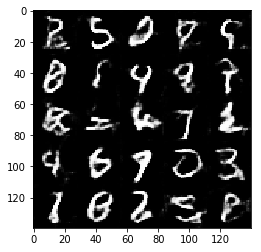

Epoch 2/2 Batch# 1610... Discriminator Loss: 1.3461... Generator Loss: 0.7045
Epoch 2/2 Batch# 1620... Discriminator Loss: 1.4849... Generator Loss: 0.7559
Epoch 2/2 Batch# 1630... Discriminator Loss: 1.3944... Generator Loss: 0.6723
Epoch 2/2 Batch# 1640... Discriminator Loss: 1.4289... Generator Loss: 1.0130
Epoch 2/2 Batch# 1650... Discriminator Loss: 1.3609... Generator Loss: 0.8281
Epoch 2/2 Batch# 1660... Discriminator Loss: 1.3814... Generator Loss: 0.6727
Epoch 2/2 Batch# 1670... Discriminator Loss: 1.4332... Generator Loss: 0.8771
Epoch 2/2 Batch# 1680... Discriminator Loss: 1.5016... Generator Loss: 0.5789
Epoch 2/2 Batch# 1690... Discriminator Loss: 1.4855... Generator Loss: 0.5766
Epoch 2/2 Batch# 1700... Discriminator Loss: 1.3451... Generator Loss: 0.7807


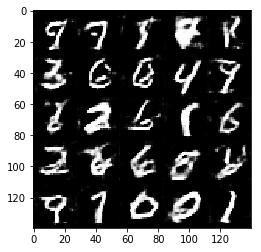

Epoch 2/2 Batch# 1710... Discriminator Loss: 1.3683... Generator Loss: 0.7309
Epoch 2/2 Batch# 1720... Discriminator Loss: 1.3804... Generator Loss: 0.7481
Epoch 2/2 Batch# 1730... Discriminator Loss: 1.4506... Generator Loss: 0.7111
Epoch 2/2 Batch# 1740... Discriminator Loss: 1.3918... Generator Loss: 0.8681
Epoch 2/2 Batch# 1750... Discriminator Loss: 1.4191... Generator Loss: 0.7766
Epoch 2/2 Batch# 1760... Discriminator Loss: 1.4252... Generator Loss: 0.6320
Epoch 2/2 Batch# 1770... Discriminator Loss: 1.4235... Generator Loss: 0.8193
Epoch 2/2 Batch# 1780... Discriminator Loss: 1.5654... Generator Loss: 0.4506
Epoch 2/2 Batch# 1790... Discriminator Loss: 1.4654... Generator Loss: 0.8791
Epoch 2/2 Batch# 1800... Discriminator Loss: 1.3850... Generator Loss: 0.7572


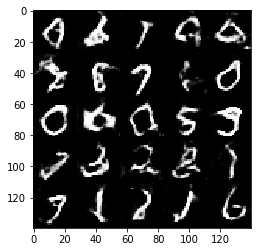

Epoch 2/2 Batch# 1810... Discriminator Loss: 1.4395... Generator Loss: 0.9181
Epoch 2/2 Batch# 1820... Discriminator Loss: 1.3940... Generator Loss: 0.9136
Epoch 2/2 Batch# 1830... Discriminator Loss: 1.6011... Generator Loss: 0.5462
Epoch 2/2 Batch# 1840... Discriminator Loss: 1.4662... Generator Loss: 0.8455
Epoch 2/2 Batch# 1850... Discriminator Loss: 1.5134... Generator Loss: 0.6143
Epoch 2/2 Batch# 1860... Discriminator Loss: 1.3946... Generator Loss: 0.8078
Epoch 2/2 Batch# 1870... Discriminator Loss: 1.3941... Generator Loss: 0.8250


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 3.5660... Generator Loss: 2.7580
Epoch 1/1 Batch# 20... Discriminator Loss: 2.5069... Generator Loss: 1.6794
Epoch 1/1 Batch# 30... Discriminator Loss: 2.8404... Generator Loss: 1.4629
Epoch 1/1 Batch# 40... Discriminator Loss: 1.6435... Generator Loss: 1.1969
Epoch 1/1 Batch# 50... Discriminator Loss: 2.3352... Generator Loss: 0.5665
Epoch 1/1 Batch# 60... Discriminator Loss: 2.6552... Generator Loss: 0.4773
Epoch 1/1 Batch# 70... Discriminator Loss: 1.9396... Generator Loss: 0.6882
Epoch 1/1 Batch# 80... Discriminator Loss: 1.8173... Generator Loss: 0.6866
Epoch 1/1 Batch# 90... Discriminator Loss: 1.7397... Generator Loss: 0.6247
Epoch 1/1 Batch# 100... Discriminator Loss: 1.9416... Generator Loss: 0.7141


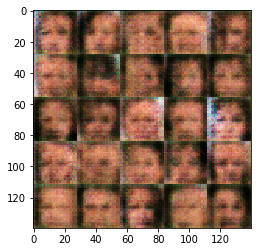

Epoch 1/1 Batch# 110... Discriminator Loss: 1.6343... Generator Loss: 0.7673
Epoch 1/1 Batch# 120... Discriminator Loss: 1.5128... Generator Loss: 0.8669
Epoch 1/1 Batch# 130... Discriminator Loss: 1.7456... Generator Loss: 0.6747
Epoch 1/1 Batch# 140... Discriminator Loss: 1.7296... Generator Loss: 0.9584
Epoch 1/1 Batch# 150... Discriminator Loss: 2.0067... Generator Loss: 0.6325
Epoch 1/1 Batch# 160... Discriminator Loss: 1.4672... Generator Loss: 0.9240
Epoch 1/1 Batch# 170... Discriminator Loss: 1.8318... Generator Loss: 0.7822
Epoch 1/1 Batch# 180... Discriminator Loss: 1.5657... Generator Loss: 0.7649
Epoch 1/1 Batch# 190... Discriminator Loss: 1.5231... Generator Loss: 0.6727
Epoch 1/1 Batch# 200... Discriminator Loss: 1.7273... Generator Loss: 0.6814


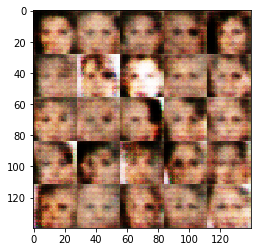

Epoch 1/1 Batch# 210... Discriminator Loss: 1.6234... Generator Loss: 0.8264
Epoch 1/1 Batch# 220... Discriminator Loss: 1.5832... Generator Loss: 0.6815
Epoch 1/1 Batch# 230... Discriminator Loss: 1.4304... Generator Loss: 0.8218
Epoch 1/1 Batch# 240... Discriminator Loss: 1.6070... Generator Loss: 0.9568
Epoch 1/1 Batch# 250... Discriminator Loss: 1.9618... Generator Loss: 0.5663
Epoch 1/1 Batch# 260... Discriminator Loss: 1.5970... Generator Loss: 0.9901
Epoch 1/1 Batch# 270... Discriminator Loss: 1.3976... Generator Loss: 0.7412
Epoch 1/1 Batch# 280... Discriminator Loss: 1.7832... Generator Loss: 0.5822
Epoch 1/1 Batch# 290... Discriminator Loss: 2.0151... Generator Loss: 0.6727
Epoch 1/1 Batch# 300... Discriminator Loss: 1.5796... Generator Loss: 0.9634


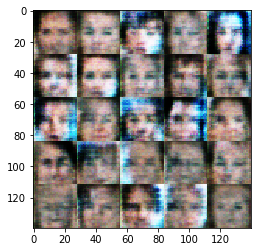

Epoch 1/1 Batch# 310... Discriminator Loss: 1.2347... Generator Loss: 1.1259
Epoch 1/1 Batch# 320... Discriminator Loss: 1.7913... Generator Loss: 0.7512
Epoch 1/1 Batch# 330... Discriminator Loss: 1.5195... Generator Loss: 0.7103
Epoch 1/1 Batch# 340... Discriminator Loss: 1.5157... Generator Loss: 0.6709
Epoch 1/1 Batch# 350... Discriminator Loss: 1.7515... Generator Loss: 0.8080
Epoch 1/1 Batch# 360... Discriminator Loss: 1.4778... Generator Loss: 0.7081
Epoch 1/1 Batch# 370... Discriminator Loss: 1.4713... Generator Loss: 0.7552
Epoch 1/1 Batch# 380... Discriminator Loss: 1.5462... Generator Loss: 0.9816
Epoch 1/1 Batch# 390... Discriminator Loss: 2.0804... Generator Loss: 0.7257
Epoch 1/1 Batch# 400... Discriminator Loss: 1.4692... Generator Loss: 1.0461


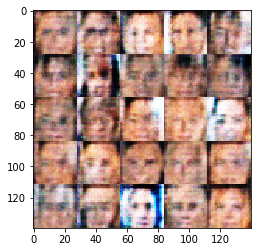

Epoch 1/1 Batch# 410... Discriminator Loss: 1.5545... Generator Loss: 0.8268
Epoch 1/1 Batch# 420... Discriminator Loss: 1.6846... Generator Loss: 0.6754
Epoch 1/1 Batch# 430... Discriminator Loss: 1.4678... Generator Loss: 0.9968
Epoch 1/1 Batch# 440... Discriminator Loss: 1.8694... Generator Loss: 0.6732
Epoch 1/1 Batch# 450... Discriminator Loss: 1.6392... Generator Loss: 0.8221
Epoch 1/1 Batch# 460... Discriminator Loss: 1.7039... Generator Loss: 0.9172
Epoch 1/1 Batch# 470... Discriminator Loss: 1.5200... Generator Loss: 0.6079
Epoch 1/1 Batch# 480... Discriminator Loss: 1.6718... Generator Loss: 0.6624
Epoch 1/1 Batch# 490... Discriminator Loss: 1.5201... Generator Loss: 0.6505
Epoch 1/1 Batch# 500... Discriminator Loss: 1.3665... Generator Loss: 0.6841


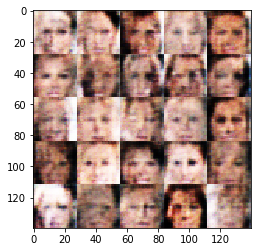

Epoch 1/1 Batch# 510... Discriminator Loss: 1.5409... Generator Loss: 0.6613
Epoch 1/1 Batch# 520... Discriminator Loss: 1.4293... Generator Loss: 0.7303
Epoch 1/1 Batch# 530... Discriminator Loss: 1.4617... Generator Loss: 0.7776
Epoch 1/1 Batch# 540... Discriminator Loss: 1.4832... Generator Loss: 0.8644
Epoch 1/1 Batch# 550... Discriminator Loss: 1.6522... Generator Loss: 0.8914
Epoch 1/1 Batch# 560... Discriminator Loss: 1.4429... Generator Loss: 0.7674
Epoch 1/1 Batch# 570... Discriminator Loss: 1.4857... Generator Loss: 0.8390
Epoch 1/1 Batch# 580... Discriminator Loss: 1.4396... Generator Loss: 1.0389
Epoch 1/1 Batch# 590... Discriminator Loss: 1.5155... Generator Loss: 0.7764
Epoch 1/1 Batch# 600... Discriminator Loss: 1.3849... Generator Loss: 0.6154


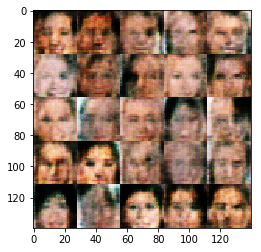

Epoch 1/1 Batch# 610... Discriminator Loss: 1.6310... Generator Loss: 0.7517
Epoch 1/1 Batch# 620... Discriminator Loss: 1.7151... Generator Loss: 0.8679
Epoch 1/1 Batch# 630... Discriminator Loss: 1.5004... Generator Loss: 0.7191
Epoch 1/1 Batch# 640... Discriminator Loss: 1.6347... Generator Loss: 0.6562
Epoch 1/1 Batch# 650... Discriminator Loss: 1.4578... Generator Loss: 0.8344
Epoch 1/1 Batch# 660... Discriminator Loss: 1.3761... Generator Loss: 0.8223
Epoch 1/1 Batch# 670... Discriminator Loss: 1.5163... Generator Loss: 0.8216
Epoch 1/1 Batch# 680... Discriminator Loss: 1.6756... Generator Loss: 0.7455
Epoch 1/1 Batch# 690... Discriminator Loss: 1.4570... Generator Loss: 0.7633
Epoch 1/1 Batch# 700... Discriminator Loss: 1.4889... Generator Loss: 0.7279


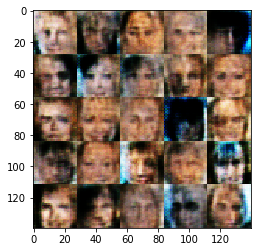

Epoch 1/1 Batch# 710... Discriminator Loss: 1.4772... Generator Loss: 0.7644
Epoch 1/1 Batch# 720... Discriminator Loss: 1.3176... Generator Loss: 0.8634
Epoch 1/1 Batch# 730... Discriminator Loss: 1.7225... Generator Loss: 0.7862
Epoch 1/1 Batch# 740... Discriminator Loss: 1.3769... Generator Loss: 0.7246
Epoch 1/1 Batch# 750... Discriminator Loss: 1.5216... Generator Loss: 0.8715
Epoch 1/1 Batch# 760... Discriminator Loss: 1.3782... Generator Loss: 0.7170
Epoch 1/1 Batch# 770... Discriminator Loss: 1.5855... Generator Loss: 0.5827
Epoch 1/1 Batch# 780... Discriminator Loss: 1.4260... Generator Loss: 0.7948
Epoch 1/1 Batch# 790... Discriminator Loss: 1.3775... Generator Loss: 0.7399
Epoch 1/1 Batch# 800... Discriminator Loss: 1.4561... Generator Loss: 0.7389


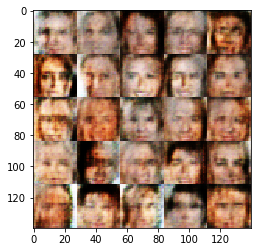

Epoch 1/1 Batch# 810... Discriminator Loss: 1.4290... Generator Loss: 0.8047
Epoch 1/1 Batch# 820... Discriminator Loss: 1.4252... Generator Loss: 0.8121
Epoch 1/1 Batch# 830... Discriminator Loss: 1.4094... Generator Loss: 0.8167
Epoch 1/1 Batch# 840... Discriminator Loss: 1.4248... Generator Loss: 0.6956
Epoch 1/1 Batch# 850... Discriminator Loss: 1.3770... Generator Loss: 0.8169
Epoch 1/1 Batch# 860... Discriminator Loss: 1.5510... Generator Loss: 0.6655
Epoch 1/1 Batch# 870... Discriminator Loss: 1.5033... Generator Loss: 0.7754
Epoch 1/1 Batch# 880... Discriminator Loss: 1.4267... Generator Loss: 0.7391
Epoch 1/1 Batch# 890... Discriminator Loss: 1.5761... Generator Loss: 0.7795
Epoch 1/1 Batch# 900... Discriminator Loss: 1.4500... Generator Loss: 0.7235


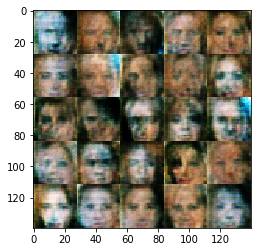

Epoch 1/1 Batch# 910... Discriminator Loss: 1.4556... Generator Loss: 0.7517
Epoch 1/1 Batch# 920... Discriminator Loss: 1.4134... Generator Loss: 0.7715
Epoch 1/1 Batch# 930... Discriminator Loss: 1.4952... Generator Loss: 0.9146
Epoch 1/1 Batch# 940... Discriminator Loss: 1.4285... Generator Loss: 0.8697
Epoch 1/1 Batch# 950... Discriminator Loss: 1.4736... Generator Loss: 0.7013
Epoch 1/1 Batch# 960... Discriminator Loss: 1.3915... Generator Loss: 0.8404
Epoch 1/1 Batch# 970... Discriminator Loss: 1.4096... Generator Loss: 0.8793
Epoch 1/1 Batch# 980... Discriminator Loss: 1.4185... Generator Loss: 0.7783
Epoch 1/1 Batch# 990... Discriminator Loss: 1.4447... Generator Loss: 0.7895
Epoch 1/1 Batch# 1000... Discriminator Loss: 1.4358... Generator Loss: 0.7689


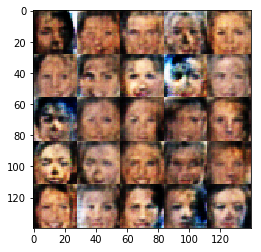

Epoch 1/1 Batch# 1010... Discriminator Loss: 1.5193... Generator Loss: 0.6461
Epoch 1/1 Batch# 1020... Discriminator Loss: 1.4489... Generator Loss: 0.7358
Epoch 1/1 Batch# 1030... Discriminator Loss: 1.5664... Generator Loss: 0.6984
Epoch 1/1 Batch# 1040... Discriminator Loss: 1.5093... Generator Loss: 0.7861
Epoch 1/1 Batch# 1050... Discriminator Loss: 1.4622... Generator Loss: 0.8183
Epoch 1/1 Batch# 1060... Discriminator Loss: 1.5290... Generator Loss: 0.6056
Epoch 1/1 Batch# 1070... Discriminator Loss: 1.5173... Generator Loss: 0.8833
Epoch 1/1 Batch# 1080... Discriminator Loss: 1.4958... Generator Loss: 0.7957
Epoch 1/1 Batch# 1090... Discriminator Loss: 1.4359... Generator Loss: 0.7973
Epoch 1/1 Batch# 1100... Discriminator Loss: 1.4313... Generator Loss: 0.8181


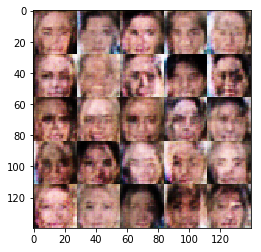

Epoch 1/1 Batch# 1110... Discriminator Loss: 1.4179... Generator Loss: 0.7889
Epoch 1/1 Batch# 1120... Discriminator Loss: 1.4758... Generator Loss: 0.7787
Epoch 1/1 Batch# 1130... Discriminator Loss: 1.5313... Generator Loss: 0.7080
Epoch 1/1 Batch# 1140... Discriminator Loss: 1.3430... Generator Loss: 0.7331
Epoch 1/1 Batch# 1150... Discriminator Loss: 1.4508... Generator Loss: 0.6083
Epoch 1/1 Batch# 1160... Discriminator Loss: 1.4285... Generator Loss: 0.7178
Epoch 1/1 Batch# 1170... Discriminator Loss: 1.3807... Generator Loss: 0.7488
Epoch 1/1 Batch# 1180... Discriminator Loss: 1.4008... Generator Loss: 0.7489
Epoch 1/1 Batch# 1190... Discriminator Loss: 1.5067... Generator Loss: 0.5980
Epoch 1/1 Batch# 1200... Discriminator Loss: 1.1758... Generator Loss: 0.8358


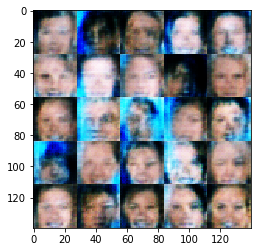

Epoch 1/1 Batch# 1210... Discriminator Loss: 1.4997... Generator Loss: 0.6300
Epoch 1/1 Batch# 1220... Discriminator Loss: 1.4232... Generator Loss: 0.8006
Epoch 1/1 Batch# 1230... Discriminator Loss: 1.3788... Generator Loss: 0.6912
Epoch 1/1 Batch# 1240... Discriminator Loss: 1.4462... Generator Loss: 0.7727
Epoch 1/1 Batch# 1250... Discriminator Loss: 1.5402... Generator Loss: 0.5816
Epoch 1/1 Batch# 1260... Discriminator Loss: 1.5227... Generator Loss: 0.6431
Epoch 1/1 Batch# 1270... Discriminator Loss: 1.4586... Generator Loss: 0.7682
Epoch 1/1 Batch# 1280... Discriminator Loss: 1.4113... Generator Loss: 0.8274
Epoch 1/1 Batch# 1290... Discriminator Loss: 1.3988... Generator Loss: 0.8295
Epoch 1/1 Batch# 1300... Discriminator Loss: 1.4194... Generator Loss: 0.7518


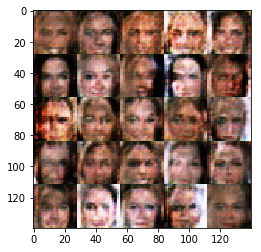

Epoch 1/1 Batch# 1310... Discriminator Loss: 1.4305... Generator Loss: 0.7668
Epoch 1/1 Batch# 1320... Discriminator Loss: 1.4498... Generator Loss: 0.6740
Epoch 1/1 Batch# 1330... Discriminator Loss: 1.4823... Generator Loss: 0.7566
Epoch 1/1 Batch# 1340... Discriminator Loss: 1.4417... Generator Loss: 0.6721
Epoch 1/1 Batch# 1350... Discriminator Loss: 1.4614... Generator Loss: 0.8159
Epoch 1/1 Batch# 1360... Discriminator Loss: 1.4365... Generator Loss: 0.7459
Epoch 1/1 Batch# 1370... Discriminator Loss: 1.5092... Generator Loss: 0.7406
Epoch 1/1 Batch# 1380... Discriminator Loss: 1.5000... Generator Loss: 0.7962
Epoch 1/1 Batch# 1390... Discriminator Loss: 1.3803... Generator Loss: 0.6976
Epoch 1/1 Batch# 1400... Discriminator Loss: 1.4676... Generator Loss: 0.7299


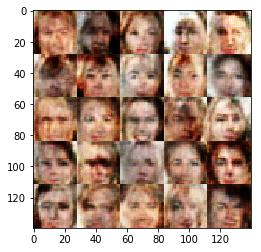

Epoch 1/1 Batch# 1410... Discriminator Loss: 1.3709... Generator Loss: 0.7638
Epoch 1/1 Batch# 1420... Discriminator Loss: 1.3918... Generator Loss: 0.8088
Epoch 1/1 Batch# 1430... Discriminator Loss: 1.4507... Generator Loss: 0.7462
Epoch 1/1 Batch# 1440... Discriminator Loss: 1.4188... Generator Loss: 0.7357
Epoch 1/1 Batch# 1450... Discriminator Loss: 1.4053... Generator Loss: 0.8204
Epoch 1/1 Batch# 1460... Discriminator Loss: 1.4102... Generator Loss: 0.7302
Epoch 1/1 Batch# 1470... Discriminator Loss: 1.4533... Generator Loss: 0.6125
Epoch 1/1 Batch# 1480... Discriminator Loss: 1.2732... Generator Loss: 0.9524
Epoch 1/1 Batch# 1490... Discriminator Loss: 1.5148... Generator Loss: 0.8417
Epoch 1/1 Batch# 1500... Discriminator Loss: 1.3370... Generator Loss: 0.8200


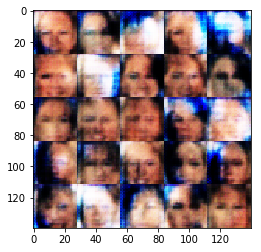

Epoch 1/1 Batch# 1510... Discriminator Loss: 1.4205... Generator Loss: 0.7021
Epoch 1/1 Batch# 1520... Discriminator Loss: 1.3343... Generator Loss: 0.7515
Epoch 1/1 Batch# 1530... Discriminator Loss: 1.5069... Generator Loss: 0.6596
Epoch 1/1 Batch# 1540... Discriminator Loss: 1.3247... Generator Loss: 0.7771
Epoch 1/1 Batch# 1550... Discriminator Loss: 1.5107... Generator Loss: 1.0181
Epoch 1/1 Batch# 1560... Discriminator Loss: 1.5448... Generator Loss: 0.6019
Epoch 1/1 Batch# 1570... Discriminator Loss: 1.3796... Generator Loss: 0.7148
Epoch 1/1 Batch# 1580... Discriminator Loss: 1.4739... Generator Loss: 0.7220
Epoch 1/1 Batch# 1590... Discriminator Loss: 1.5451... Generator Loss: 0.7095
Epoch 1/1 Batch# 1600... Discriminator Loss: 1.4628... Generator Loss: 0.6564


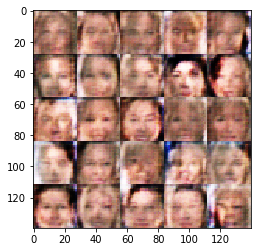

Epoch 1/1 Batch# 1610... Discriminator Loss: 1.4284... Generator Loss: 0.7089
Epoch 1/1 Batch# 1620... Discriminator Loss: 1.4641... Generator Loss: 0.7067
Epoch 1/1 Batch# 1630... Discriminator Loss: 1.5081... Generator Loss: 0.8019
Epoch 1/1 Batch# 1640... Discriminator Loss: 1.5174... Generator Loss: 0.7470
Epoch 1/1 Batch# 1650... Discriminator Loss: 1.3987... Generator Loss: 0.7355
Epoch 1/1 Batch# 1660... Discriminator Loss: 1.4635... Generator Loss: 0.6516
Epoch 1/1 Batch# 1670... Discriminator Loss: 1.4192... Generator Loss: 0.7237
Epoch 1/1 Batch# 1680... Discriminator Loss: 1.4229... Generator Loss: 0.7590
Epoch 1/1 Batch# 1690... Discriminator Loss: 1.4012... Generator Loss: 0.7974
Epoch 1/1 Batch# 1700... Discriminator Loss: 1.4026... Generator Loss: 0.7023


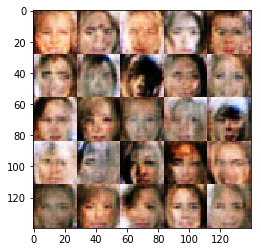

Epoch 1/1 Batch# 1710... Discriminator Loss: 1.4098... Generator Loss: 0.6649
Epoch 1/1 Batch# 1720... Discriminator Loss: 1.4702... Generator Loss: 0.6021
Epoch 1/1 Batch# 1730... Discriminator Loss: 1.3865... Generator Loss: 0.6737
Epoch 1/1 Batch# 1740... Discriminator Loss: 1.4484... Generator Loss: 0.8505
Epoch 1/1 Batch# 1750... Discriminator Loss: 1.3963... Generator Loss: 0.7245
Epoch 1/1 Batch# 1760... Discriminator Loss: 1.5048... Generator Loss: 0.6413
Epoch 1/1 Batch# 1770... Discriminator Loss: 1.4243... Generator Loss: 0.7505
Epoch 1/1 Batch# 1780... Discriminator Loss: 1.3598... Generator Loss: 0.8355
Epoch 1/1 Batch# 1790... Discriminator Loss: 1.3959... Generator Loss: 0.7439
Epoch 1/1 Batch# 1800... Discriminator Loss: 1.4765... Generator Loss: 0.6347


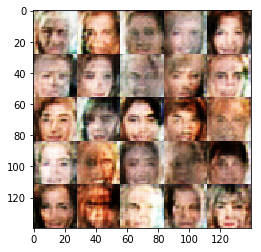

Epoch 1/1 Batch# 1810... Discriminator Loss: 1.3882... Generator Loss: 0.7537
Epoch 1/1 Batch# 1820... Discriminator Loss: 1.4556... Generator Loss: 0.7096
Epoch 1/1 Batch# 1830... Discriminator Loss: 1.4282... Generator Loss: 0.7175
Epoch 1/1 Batch# 1840... Discriminator Loss: 1.3940... Generator Loss: 0.8122
Epoch 1/1 Batch# 1850... Discriminator Loss: 1.3891... Generator Loss: 0.7292
Epoch 1/1 Batch# 1860... Discriminator Loss: 1.3305... Generator Loss: 0.6825
Epoch 1/1 Batch# 1870... Discriminator Loss: 1.4553... Generator Loss: 0.7030
Epoch 1/1 Batch# 1880... Discriminator Loss: 1.3510... Generator Loss: 0.7331
Epoch 1/1 Batch# 1890... Discriminator Loss: 1.4529... Generator Loss: 0.6690
Epoch 1/1 Batch# 1900... Discriminator Loss: 1.3858... Generator Loss: 0.6972


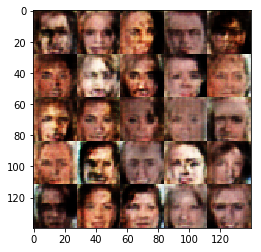

Epoch 1/1 Batch# 1910... Discriminator Loss: 1.3847... Generator Loss: 0.8036
Epoch 1/1 Batch# 1920... Discriminator Loss: 1.3733... Generator Loss: 0.8393
Epoch 1/1 Batch# 1930... Discriminator Loss: 1.3909... Generator Loss: 0.7121
Epoch 1/1 Batch# 1940... Discriminator Loss: 1.4567... Generator Loss: 0.8604
Epoch 1/1 Batch# 1950... Discriminator Loss: 1.3980... Generator Loss: 0.7323
Epoch 1/1 Batch# 1960... Discriminator Loss: 1.4848... Generator Loss: 0.7432
Epoch 1/1 Batch# 1970... Discriminator Loss: 1.4060... Generator Loss: 0.8033
Epoch 1/1 Batch# 1980... Discriminator Loss: 1.4793... Generator Loss: 0.6612
Epoch 1/1 Batch# 1990... Discriminator Loss: 1.4532... Generator Loss: 0.6914
Epoch 1/1 Batch# 2000... Discriminator Loss: 1.4274... Generator Loss: 0.7126


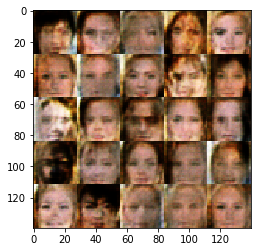

Epoch 1/1 Batch# 2010... Discriminator Loss: 1.4611... Generator Loss: 0.7605
Epoch 1/1 Batch# 2020... Discriminator Loss: 1.3541... Generator Loss: 0.7281
Epoch 1/1 Batch# 2030... Discriminator Loss: 1.4589... Generator Loss: 0.7523
Epoch 1/1 Batch# 2040... Discriminator Loss: 1.3936... Generator Loss: 0.7465
Epoch 1/1 Batch# 2050... Discriminator Loss: 1.3993... Generator Loss: 0.7442
Epoch 1/1 Batch# 2060... Discriminator Loss: 1.4438... Generator Loss: 0.7430
Epoch 1/1 Batch# 2070... Discriminator Loss: 1.5276... Generator Loss: 0.7924
Epoch 1/1 Batch# 2080... Discriminator Loss: 1.3591... Generator Loss: 0.7749
Epoch 1/1 Batch# 2090... Discriminator Loss: 1.4558... Generator Loss: 0.7670
Epoch 1/1 Batch# 2100... Discriminator Loss: 1.3793... Generator Loss: 0.7929


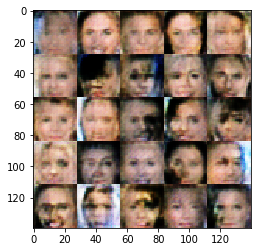

Epoch 1/1 Batch# 2110... Discriminator Loss: 1.3605... Generator Loss: 0.7724
Epoch 1/1 Batch# 2120... Discriminator Loss: 1.3555... Generator Loss: 0.7945
Epoch 1/1 Batch# 2130... Discriminator Loss: 1.4107... Generator Loss: 0.6953
Epoch 1/1 Batch# 2140... Discriminator Loss: 1.5522... Generator Loss: 0.6157
Epoch 1/1 Batch# 2150... Discriminator Loss: 1.4249... Generator Loss: 0.7237
Epoch 1/1 Batch# 2160... Discriminator Loss: 1.3877... Generator Loss: 0.7016
Epoch 1/1 Batch# 2170... Discriminator Loss: 1.3809... Generator Loss: 0.7257
Epoch 1/1 Batch# 2180... Discriminator Loss: 1.3660... Generator Loss: 0.7353
Epoch 1/1 Batch# 2190... Discriminator Loss: 1.3663... Generator Loss: 0.7125
Epoch 1/1 Batch# 2200... Discriminator Loss: 1.4935... Generator Loss: 0.6728


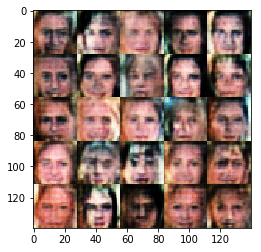

Epoch 1/1 Batch# 2210... Discriminator Loss: 1.4119... Generator Loss: 0.7429
Epoch 1/1 Batch# 2220... Discriminator Loss: 1.3879... Generator Loss: 0.7231
Epoch 1/1 Batch# 2230... Discriminator Loss: 1.4276... Generator Loss: 0.7370
Epoch 1/1 Batch# 2240... Discriminator Loss: 1.3099... Generator Loss: 0.8422
Epoch 1/1 Batch# 2250... Discriminator Loss: 1.4207... Generator Loss: 0.7289
Epoch 1/1 Batch# 2260... Discriminator Loss: 1.3379... Generator Loss: 0.7361
Epoch 1/1 Batch# 2270... Discriminator Loss: 1.6170... Generator Loss: 0.5196
Epoch 1/1 Batch# 2280... Discriminator Loss: 1.4339... Generator Loss: 0.6861
Epoch 1/1 Batch# 2290... Discriminator Loss: 1.4468... Generator Loss: 0.7785
Epoch 1/1 Batch# 2300... Discriminator Loss: 1.4626... Generator Loss: 0.7049


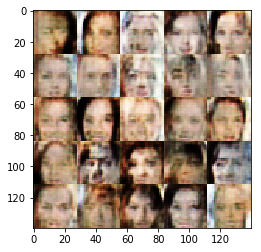

Epoch 1/1 Batch# 2310... Discriminator Loss: 1.3999... Generator Loss: 0.7475
Epoch 1/1 Batch# 2320... Discriminator Loss: 1.4152... Generator Loss: 0.7162
Epoch 1/1 Batch# 2330... Discriminator Loss: 1.3808... Generator Loss: 0.7375
Epoch 1/1 Batch# 2340... Discriminator Loss: 1.4140... Generator Loss: 0.7518
Epoch 1/1 Batch# 2350... Discriminator Loss: 1.4678... Generator Loss: 0.6597
Epoch 1/1 Batch# 2360... Discriminator Loss: 1.4041... Generator Loss: 0.7673
Epoch 1/1 Batch# 2370... Discriminator Loss: 1.4088... Generator Loss: 0.7439
Epoch 1/1 Batch# 2380... Discriminator Loss: 1.4965... Generator Loss: 0.8409
Epoch 1/1 Batch# 2390... Discriminator Loss: 1.3791... Generator Loss: 0.7682
Epoch 1/1 Batch# 2400... Discriminator Loss: 1.4144... Generator Loss: 0.7191


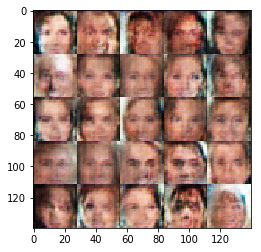

Epoch 1/1 Batch# 2410... Discriminator Loss: 1.4597... Generator Loss: 0.8065
Epoch 1/1 Batch# 2420... Discriminator Loss: 1.3374... Generator Loss: 0.7487
Epoch 1/1 Batch# 2430... Discriminator Loss: 1.4283... Generator Loss: 0.6648
Epoch 1/1 Batch# 2440... Discriminator Loss: 1.3955... Generator Loss: 0.7327
Epoch 1/1 Batch# 2450... Discriminator Loss: 1.3731... Generator Loss: 0.7229
Epoch 1/1 Batch# 2460... Discriminator Loss: 1.3438... Generator Loss: 0.7947
Epoch 1/1 Batch# 2470... Discriminator Loss: 1.4406... Generator Loss: 0.7565
Epoch 1/1 Batch# 2480... Discriminator Loss: 1.3863... Generator Loss: 0.7498
Epoch 1/1 Batch# 2490... Discriminator Loss: 1.4015... Generator Loss: 0.7256
Epoch 1/1 Batch# 2500... Discriminator Loss: 1.4975... Generator Loss: 0.7039


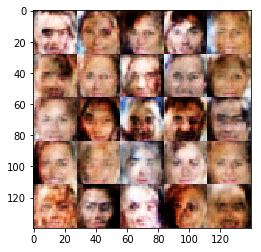

Epoch 1/1 Batch# 2510... Discriminator Loss: 1.4209... Generator Loss: 0.7423
Epoch 1/1 Batch# 2520... Discriminator Loss: 1.4165... Generator Loss: 0.6808
Epoch 1/1 Batch# 2530... Discriminator Loss: 1.5095... Generator Loss: 0.6201
Epoch 1/1 Batch# 2540... Discriminator Loss: 1.4535... Generator Loss: 0.6644
Epoch 1/1 Batch# 2550... Discriminator Loss: 1.4252... Generator Loss: 0.8079
Epoch 1/1 Batch# 2560... Discriminator Loss: 1.4758... Generator Loss: 0.6553
Epoch 1/1 Batch# 2570... Discriminator Loss: 1.3874... Generator Loss: 0.7209
Epoch 1/1 Batch# 2580... Discriminator Loss: 1.4347... Generator Loss: 0.8597
Epoch 1/1 Batch# 2590... Discriminator Loss: 1.4091... Generator Loss: 0.7519
Epoch 1/1 Batch# 2600... Discriminator Loss: 1.3797... Generator Loss: 0.7768


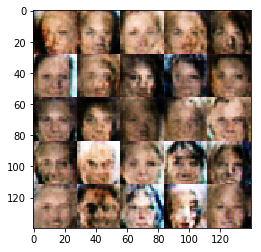

Epoch 1/1 Batch# 2610... Discriminator Loss: 1.4088... Generator Loss: 0.7562
Epoch 1/1 Batch# 2620... Discriminator Loss: 1.4056... Generator Loss: 0.7894
Epoch 1/1 Batch# 2630... Discriminator Loss: 1.3431... Generator Loss: 0.7030
Epoch 1/1 Batch# 2640... Discriminator Loss: 1.4562... Generator Loss: 0.6832
Epoch 1/1 Batch# 2650... Discriminator Loss: 1.4118... Generator Loss: 0.7002
Epoch 1/1 Batch# 2660... Discriminator Loss: 1.4342... Generator Loss: 0.7410
Epoch 1/1 Batch# 2670... Discriminator Loss: 1.4913... Generator Loss: 0.7686
Epoch 1/1 Batch# 2680... Discriminator Loss: 1.4213... Generator Loss: 0.7320
Epoch 1/1 Batch# 2690... Discriminator Loss: 1.4144... Generator Loss: 0.6937
Epoch 1/1 Batch# 2700... Discriminator Loss: 1.3657... Generator Loss: 0.7305


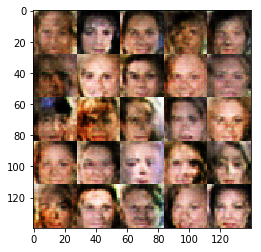

Epoch 1/1 Batch# 2710... Discriminator Loss: 1.3600... Generator Loss: 0.7642
Epoch 1/1 Batch# 2720... Discriminator Loss: 1.4110... Generator Loss: 0.7410
Epoch 1/1 Batch# 2730... Discriminator Loss: 1.3737... Generator Loss: 0.7473
Epoch 1/1 Batch# 2740... Discriminator Loss: 1.4040... Generator Loss: 0.7716
Epoch 1/1 Batch# 2750... Discriminator Loss: 1.4295... Generator Loss: 0.6527
Epoch 1/1 Batch# 2760... Discriminator Loss: 1.4206... Generator Loss: 0.6937
Epoch 1/1 Batch# 2770... Discriminator Loss: 1.4160... Generator Loss: 0.7562
Epoch 1/1 Batch# 2780... Discriminator Loss: 1.4144... Generator Loss: 0.6943
Epoch 1/1 Batch# 2790... Discriminator Loss: 1.3858... Generator Loss: 0.7550
Epoch 1/1 Batch# 2800... Discriminator Loss: 1.4004... Generator Loss: 0.7263


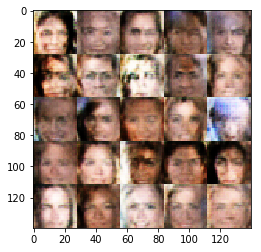

Epoch 1/1 Batch# 2810... Discriminator Loss: 1.3690... Generator Loss: 0.8113
Epoch 1/1 Batch# 2820... Discriminator Loss: 1.3824... Generator Loss: 0.7469
Epoch 1/1 Batch# 2830... Discriminator Loss: 1.4032... Generator Loss: 0.7183
Epoch 1/1 Batch# 2840... Discriminator Loss: 1.4098... Generator Loss: 0.7634
Epoch 1/1 Batch# 2850... Discriminator Loss: 1.4688... Generator Loss: 0.7204
Epoch 1/1 Batch# 2860... Discriminator Loss: 1.3946... Generator Loss: 0.6954
Epoch 1/1 Batch# 2870... Discriminator Loss: 1.4084... Generator Loss: 0.7356
Epoch 1/1 Batch# 2880... Discriminator Loss: 1.4143... Generator Loss: 0.6796
Epoch 1/1 Batch# 2890... Discriminator Loss: 1.4173... Generator Loss: 0.7944
Epoch 1/1 Batch# 2900... Discriminator Loss: 1.3803... Generator Loss: 0.7319


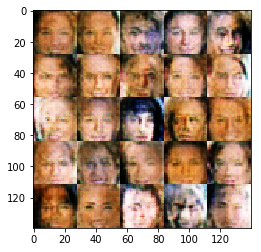

Epoch 1/1 Batch# 2910... Discriminator Loss: 1.4256... Generator Loss: 0.6699
Epoch 1/1 Batch# 2920... Discriminator Loss: 1.3716... Generator Loss: 0.7632
Epoch 1/1 Batch# 2930... Discriminator Loss: 1.4101... Generator Loss: 0.7590
Epoch 1/1 Batch# 2940... Discriminator Loss: 1.4387... Generator Loss: 0.7266
Epoch 1/1 Batch# 2950... Discriminator Loss: 1.3993... Generator Loss: 0.7749
Epoch 1/1 Batch# 2960... Discriminator Loss: 1.3966... Generator Loss: 0.6924
Epoch 1/1 Batch# 2970... Discriminator Loss: 1.4151... Generator Loss: 0.7733
Epoch 1/1 Batch# 2980... Discriminator Loss: 1.4492... Generator Loss: 0.7298
Epoch 1/1 Batch# 2990... Discriminator Loss: 1.4306... Generator Loss: 0.7446
Epoch 1/1 Batch# 3000... Discriminator Loss: 1.4592... Generator Loss: 0.6633


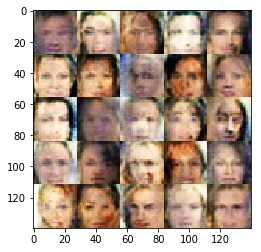

Epoch 1/1 Batch# 3010... Discriminator Loss: 1.4000... Generator Loss: 0.7780
Epoch 1/1 Batch# 3020... Discriminator Loss: 1.4265... Generator Loss: 0.6809
Epoch 1/1 Batch# 3030... Discriminator Loss: 1.3854... Generator Loss: 0.7767
Epoch 1/1 Batch# 3040... Discriminator Loss: 1.4321... Generator Loss: 0.7439
Epoch 1/1 Batch# 3050... Discriminator Loss: 1.3991... Generator Loss: 0.7576
Epoch 1/1 Batch# 3060... Discriminator Loss: 1.4319... Generator Loss: 0.7459
Epoch 1/1 Batch# 3070... Discriminator Loss: 1.3512... Generator Loss: 0.7698
Epoch 1/1 Batch# 3080... Discriminator Loss: 1.4200... Generator Loss: 0.7427
Epoch 1/1 Batch# 3090... Discriminator Loss: 1.4499... Generator Loss: 0.7412
Epoch 1/1 Batch# 3100... Discriminator Loss: 1.4539... Generator Loss: 0.6236


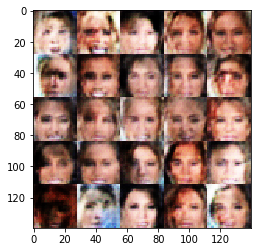

Epoch 1/1 Batch# 3110... Discriminator Loss: 1.4133... Generator Loss: 0.7279
Epoch 1/1 Batch# 3120... Discriminator Loss: 1.4174... Generator Loss: 0.7010
Epoch 1/1 Batch# 3130... Discriminator Loss: 1.4120... Generator Loss: 0.7247
Epoch 1/1 Batch# 3140... Discriminator Loss: 1.4036... Generator Loss: 0.7263
Epoch 1/1 Batch# 3150... Discriminator Loss: 1.4008... Generator Loss: 0.7623
Epoch 1/1 Batch# 3160... Discriminator Loss: 1.3956... Generator Loss: 0.7753


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.